In [1]:
import pandas as pd
import numpy as np

pd.set_option('display.max_columns', None)

path_data = "./data/trips.csv"

data = pd.read_csv(path_data, encoding="latin_1", sep=";",decimal=",")
col_melt = list(data.columns[-12:]) #last months

df_month = pd.DataFrame.from_dict(data={
    "month_name": col_melt,
    "month_value": list(range(1,13))
})

col_maintain = list(data.columns[:-12])

data_long = data.melt(id_vars=col_maintain,value_vars=col_melt,var_name="month_name")
data_long = data_long.merge(df_month, how="left",on="month_name")
def to_date(year,month):
    return pd.Timestamp(day=1, month=month, year = year)


years = data_long["Anio "].values
month_values = data_long["month_value"].values

data_long["time_stamp"] = [to_date(year,month) for year,month  in zip(years, month_values)]
data_long.drop(columns=["Anio ", "month_name", "month_value"], inplace=True)

data_region = data_long[["CUT Region Origen ", "CUT Region Destino ", "value", "time_stamp"]]
data_region = data_region.copy()

data_region.rename(columns={"CUT Region Origen ": "region_origin", "CUT Region Destino ": "region_destiny"}, inplace=True)

data_region = data_region.groupby(["region_origin", "region_destiny", "time_stamp"]).sum().reset_index()
data_region.value = np.int64(data_region.value.values)
data_region.query("value > 0", inplace=True)

In [12]:
data_region

,region_origin,region_destiny,time_stamp,value
0,1,1,2019-01-01,15015
1,1,1,2019-02-01,9955
2,1,1,2019-03-01,5360
3,1,1,2019-04-01,7603
4,1,1,2019-05-01,7407
...,...,...,...,...
15349,16,16,2023-02-01,18059
15350,16,16,2023-03-01,10682
15351,16,16,2023-04-01,10669
15352,16,16,2023-05-01,7613


In [13]:
for group, data_group in data_region.groupby(["region_origin", "region_destiny"]):
    pass

(<Figure size 1600x400 with 1 Axes>, <Axes: >)

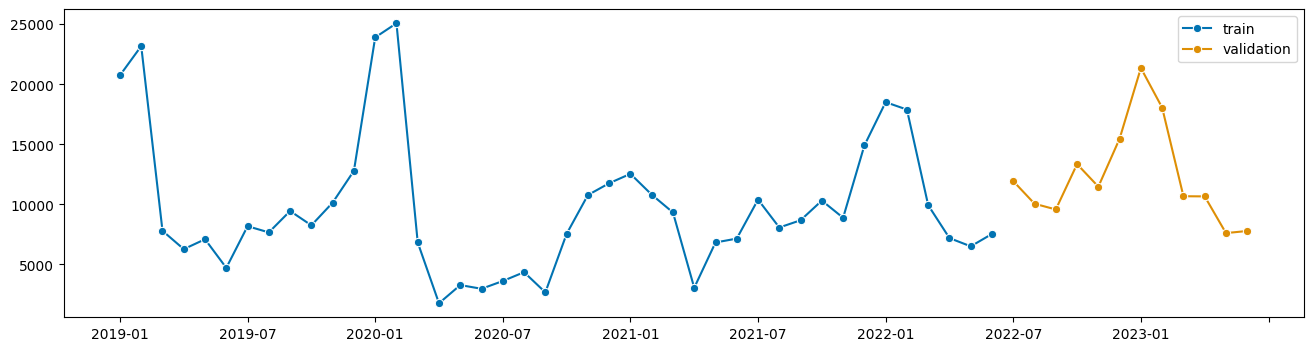

In [53]:
from sktime.forecasting.tbats import TBATS
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error
from sktime.utils.plotting import plot_series
import numpy as np

y= pd.Series(
    data_group.value.values,
    index= data_group.time_stamp.values)
y.index = y.index.to_period("M")

y_train, y_valid = temporal_train_test_split(y, test_size=12)
plot_series(y_train, y_valid, labels=["train", "validation"])


0.16043917409791372


(<Figure size 1600x400 with 1 Axes>, <Axes: >)

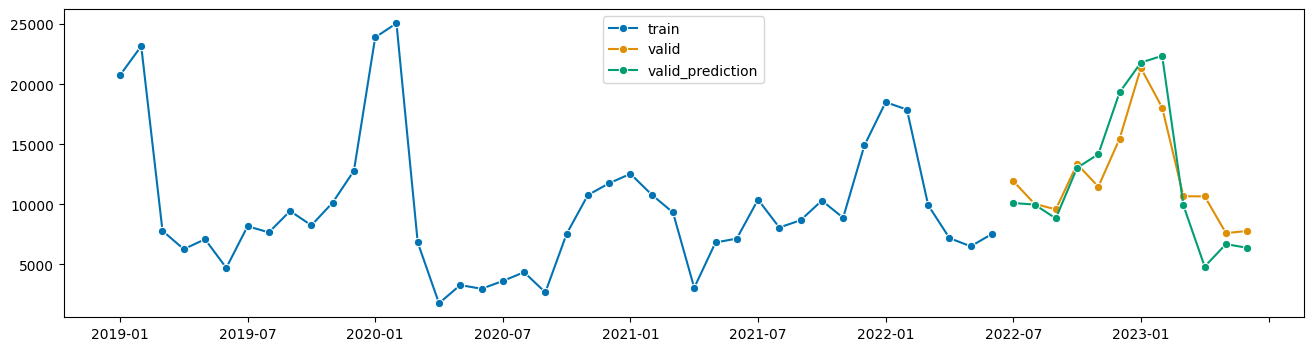

In [61]:
fh_valid = ForecastingHorizon(y_valid.index, is_relative=False)

params_model = {
    "use_box_cox": True,
    "use_arma_errors": True,
    "use_trend": True,
    "sp" : 12
}

forecaster_try = TBATS(**params_model)
forecaster_try.fit(y_train)
y_pred = forecaster_try.predict(fh_valid)
print(mean_absolute_percentage_error(y_valid, y_pred))

plot_series(y_train,y_valid, y_pred, labels= ["train", "valid", "valid_prediction"])

(<Figure size 1600x400 with 1 Axes>, <Axes: >)

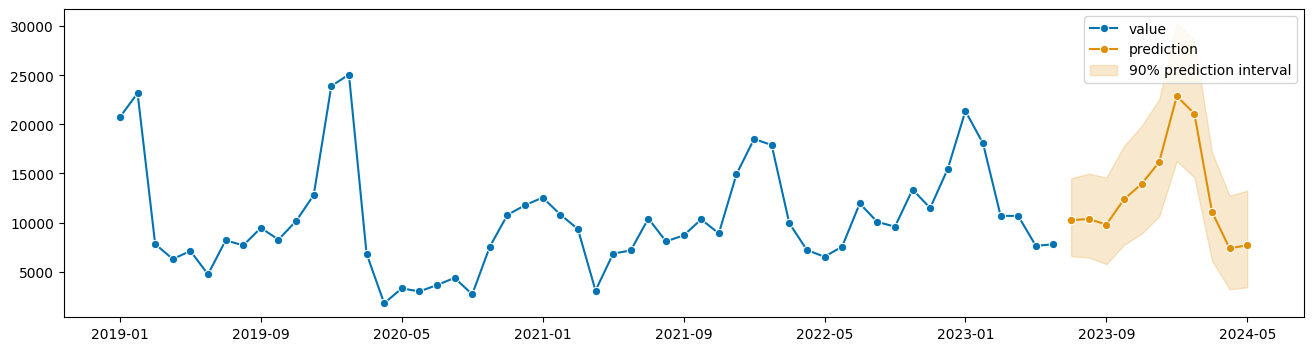

In [62]:

forecaster = TBATS(**params_model)
forecaster.fit(y)

fh = ForecastingHorizon(np.arange(1,12))
y_pred_final = forecaster.predict(fh)
y_pred_invervals = forecaster.predict_interval(fh)

plot_series(y, y_pred_final, labels = ["value", "prediction"], pred_interval=y_pred_invervals)


In [74]:
def predict_dataframe(data_grouped: pd.DataFrame, h:int = 12) -> pd.Series:
    
    y= pd.Series(
    data_grouped.value.values,
    index= data_grouped.time_stamp.values)
    
    y.index = y.index.to_period("M")
    
    
    params_model = {
    "use_box_cox": True,
    "use_arma_errors": True,
    "use_trend": True,
    "sp" : 12}
    
    forecaster = TBATS(**params_model)
    forecaster.fit(y)
    fh = ForecastingHorizon(np.arange(1,h))
    
    y_pred = forecaster.predict(fh)
    
    return y_pred
    
    



In [75]:
dict_pred = dict()

for group, data_group in data_region.groupby(["region_origin", "region_destiny"]):
    y_pred = predict_dataframe(data_group)
    dict_pred[group] = y_pred

In [82]:
import pickle as p

pred_path = "./data/preds.pkl"

with open(pred_path,"wb") as file:
    p.dump(dict_pred,file)

In [83]:
with open(pred_path, "rb") as file:
    dict_pred_pkl = p.load(file)

In [88]:
dict_df = dict()
for k,v in dict_pred_pkl.items():
    region_origin = k[0]
    region_destiny = k[1]
    df = pd.DataFrame(v)
    df["region_origin"] = region_origin
    df["region_destiny"] = region_destiny
    dict_df[k] = df

In [91]:
df_preds = pd.concat(dict_df.values())

In [94]:
df_preds.rename(columns={0: "prediction"}, inplace=True)

In [111]:
df_preds

,prediction,region_origin,region_destiny
2023-07,9691.069285,1,1
2023-08,9341.588395,1,1
2023-09,9068.141662,1,1
2023-10,8853.273009,1,1
2023-11,8683.846616,1,1
...,...,...,...
2024-01,22866.399431,16,16
2024-02,21094.627287,16,16
2024-03,11086.989519,16,16
2024-04,7355.596471,16,16


In [112]:
df_preds_destiny = df_preds.reset_index(names=["time_stamp"]).groupby(["time_stamp","region_destiny"]).sum().reset_index()
df_preds_destiny.prediction = np.int32(df_preds_destiny.prediction.values)
df_preds_destiny.drop(columns="region_origin",inplace=True)
df_preds_destiny.sort_values(["region_destiny", "time_stamp"],inplace=True)
df_preds_destiny

,time_stamp,region_destiny,prediction
0,2023-07,1,64155
16,2023-08,1,53918
32,2023-09,1,52059
48,2023-10,1,57326
64,2023-11,1,54188
...,...,...,...
111,2024-01,16,226190
127,2024-02,16,236751
143,2024-03,16,101987
159,2024-04,16,88793


In [120]:
df_destiny = data_region.groupby(["time_stamp", "region_destiny"]).sum().reset_index()
df_destiny.drop(columns=["region_origin"], inplace=True)
df_destiny["time_stamp"] = pd.DatetimeIndex(df_destiny.time_stamp).to_period("M")
df_destiny

,time_stamp,region_destiny,value
0,2019-01,1,86815
1,2019-01,2,125689
2,2019-01,3,90758
3,2019-01,4,400232
4,2019-01,5,1192485
...,...,...,...
859,2023-06,12,16954
860,2023-06,13,465280
861,2023-06,14,79159
862,2023-06,15,21776


In [125]:
df_destiny_all = pd.concat([df_destiny, df_preds_destiny])
df_destiny_all

,time_stamp,region_destiny,value,prediction
0,2019-01,1,86815.0,NaN
1,2019-01,2,125689.0,NaN
2,2019-01,3,90758.0,NaN
3,2019-01,4,400232.0,NaN
4,2019-01,5,1192485.0,NaN
...,...,...,...,...
111,2024-01,16,NaN,226190.0
127,2024-02,16,NaN,236751.0
143,2024-03,16,NaN,101987.0
159,2024-04,16,NaN,88793.0


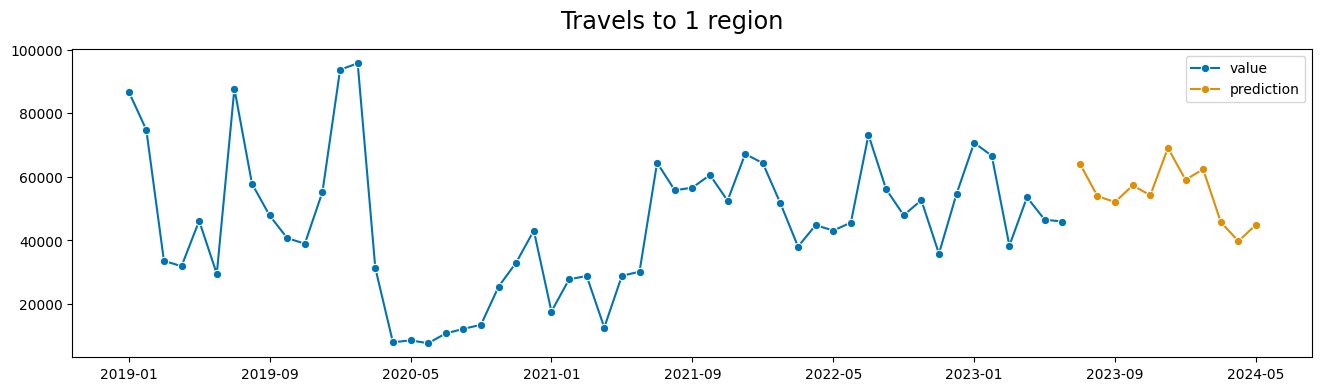

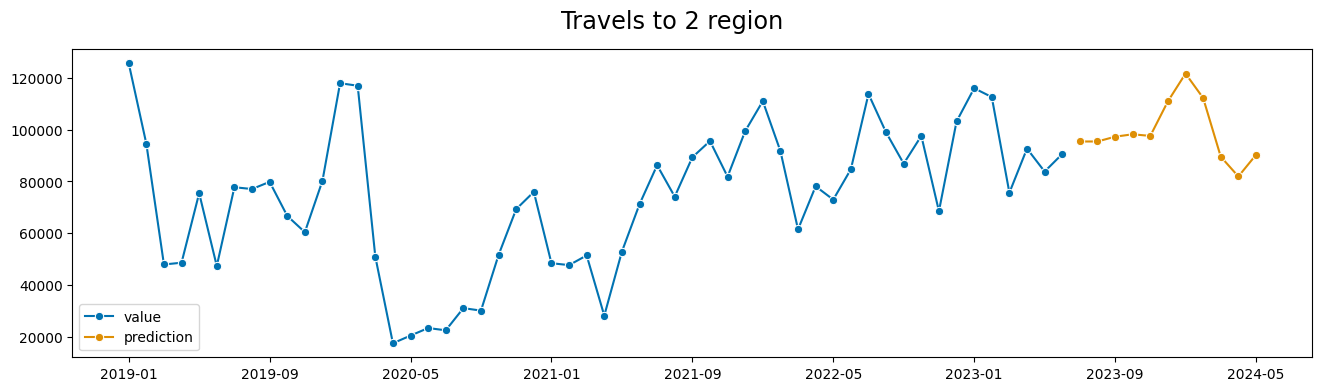

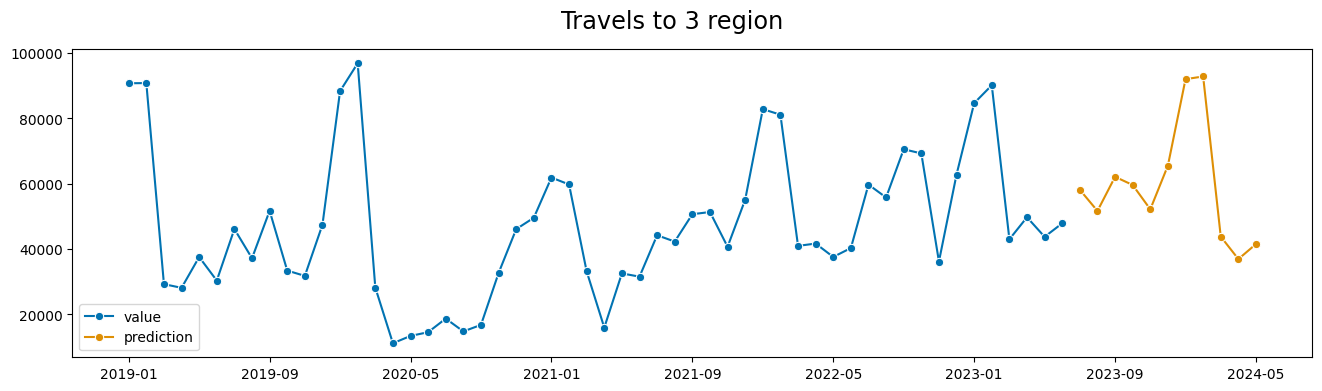

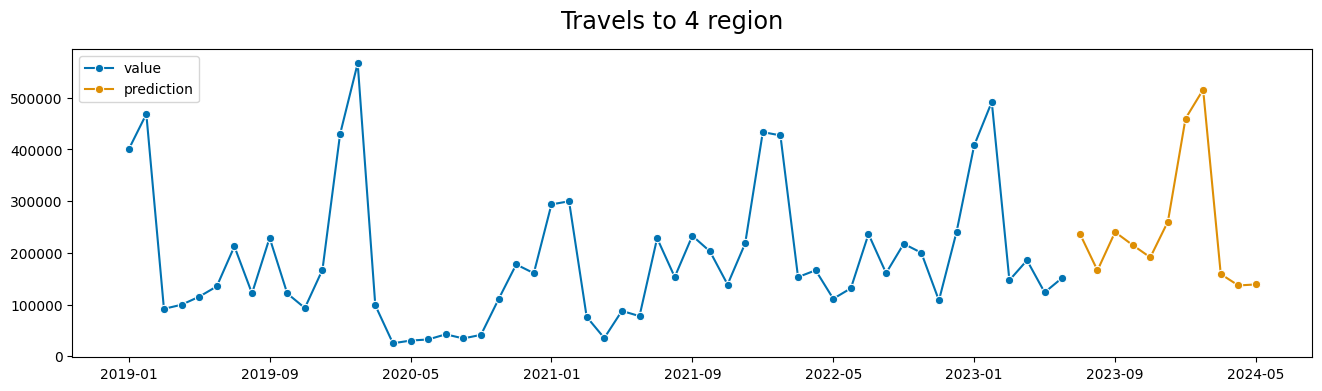

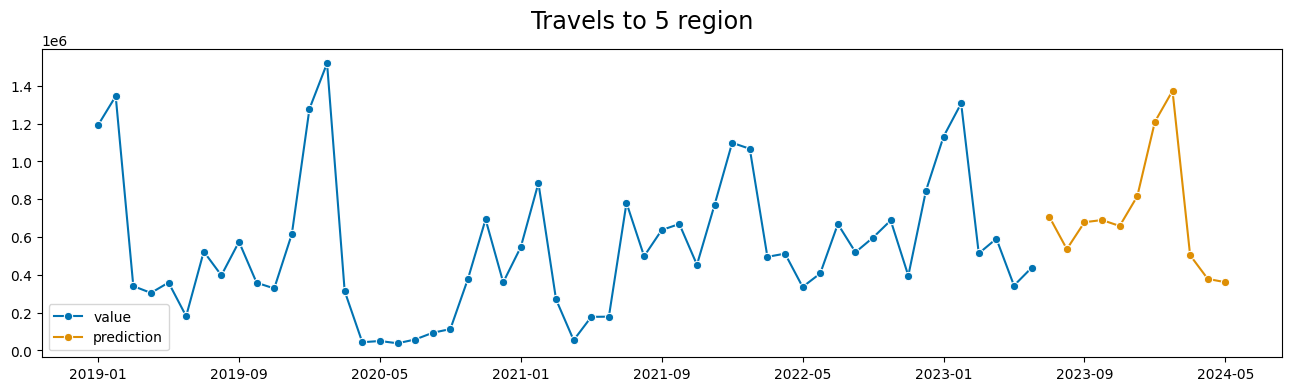

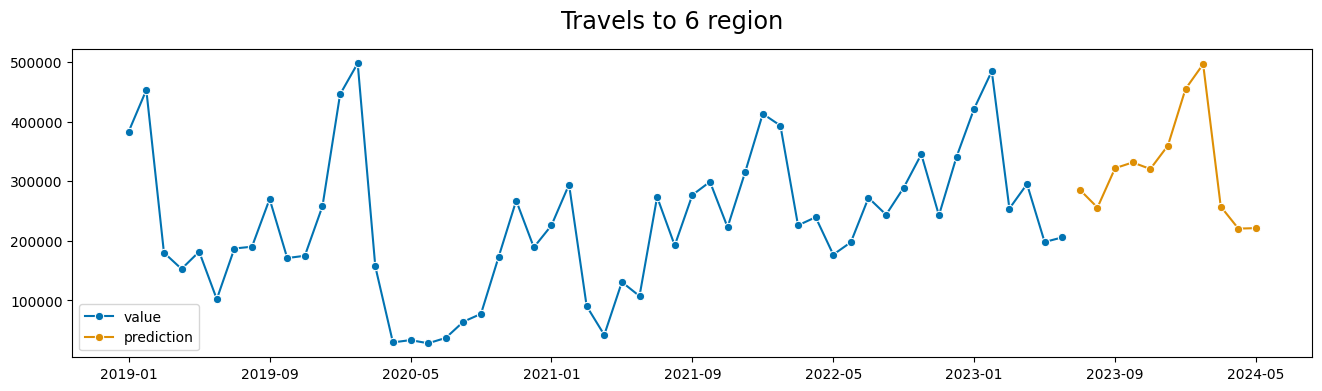

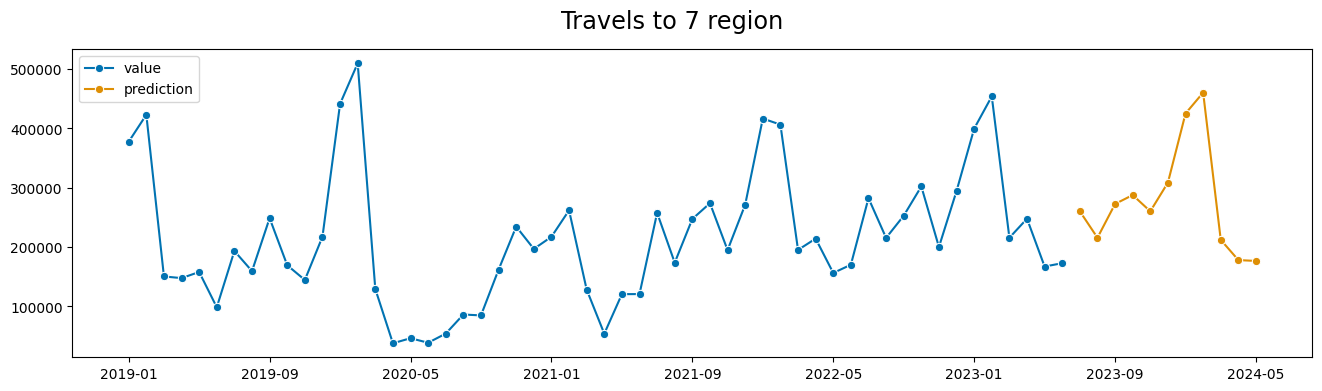

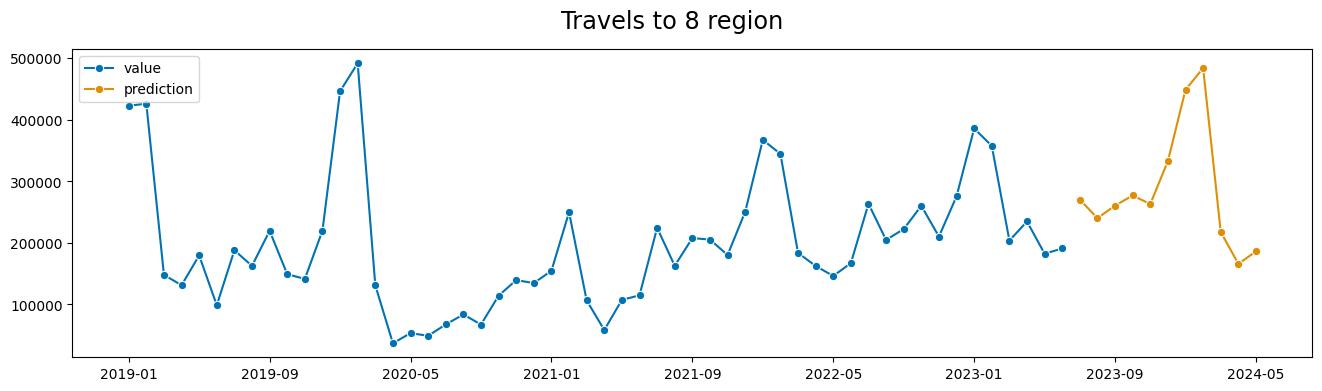

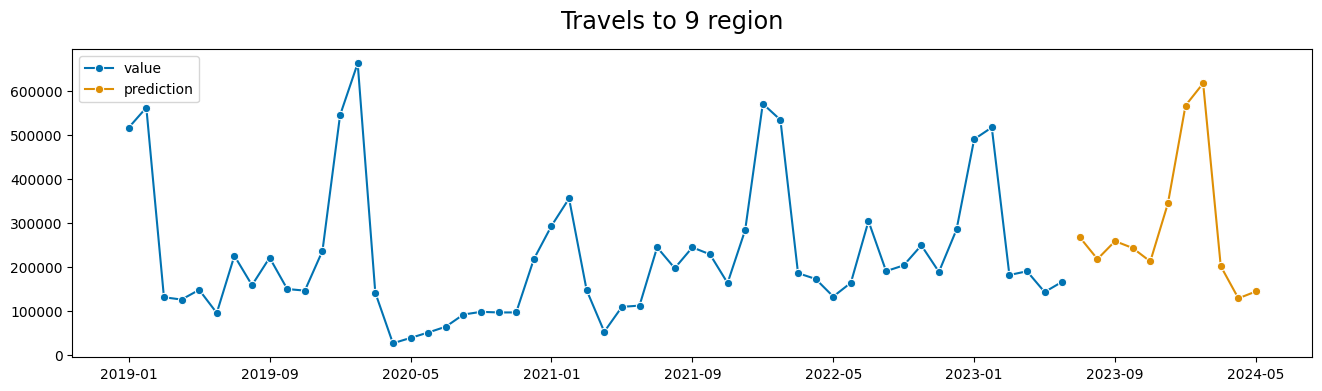

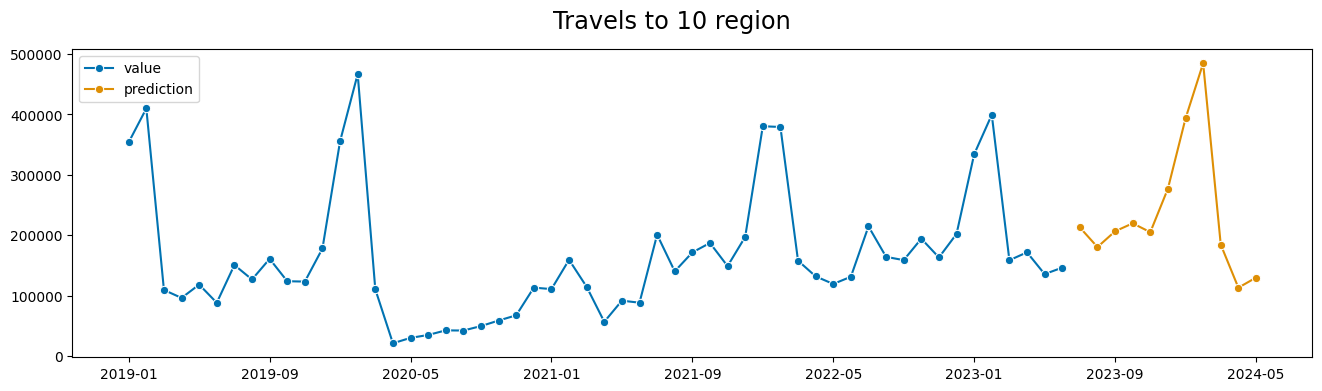

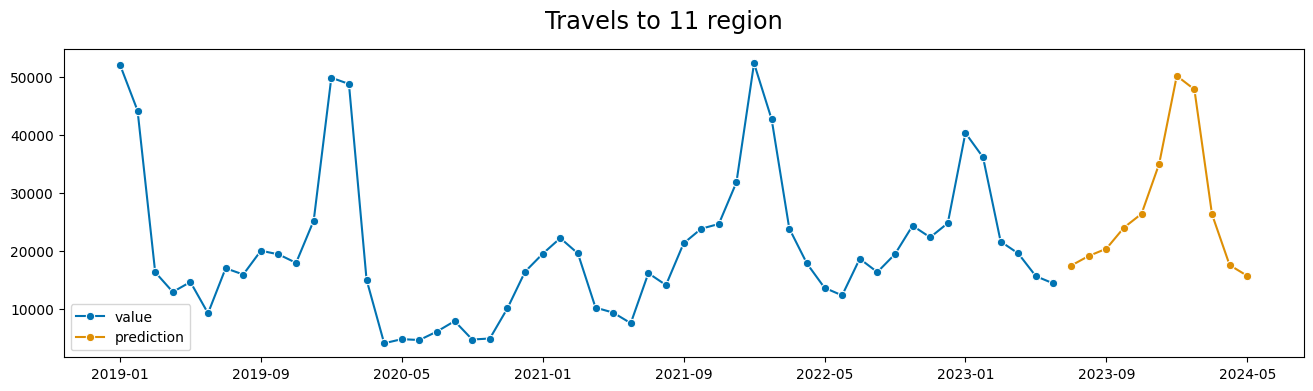

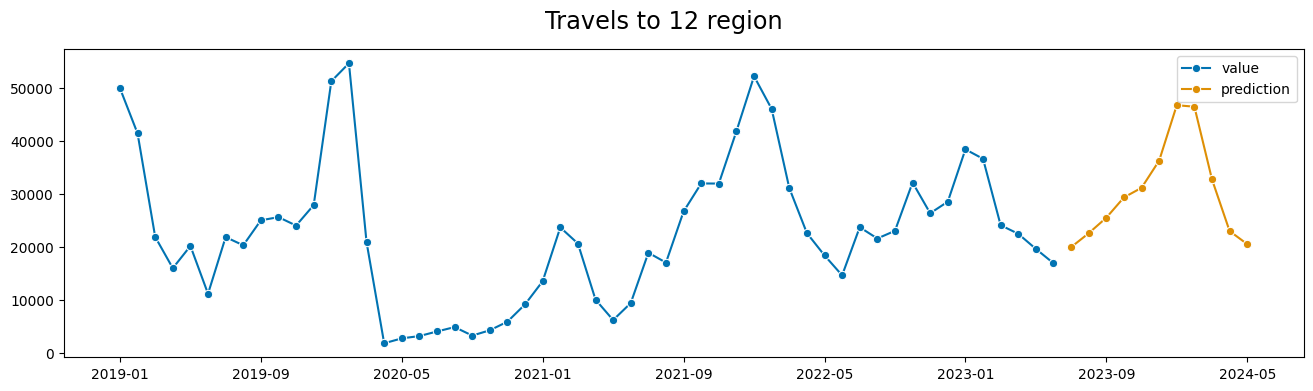

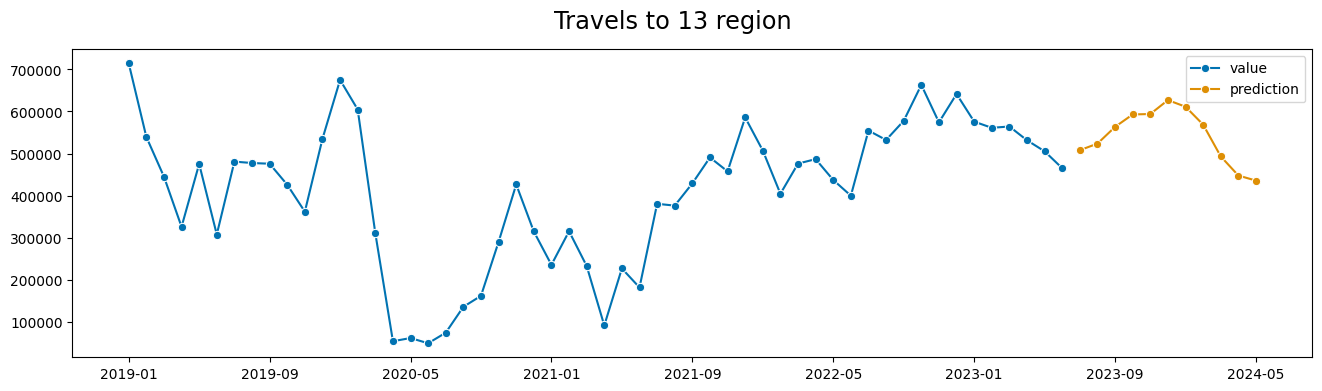

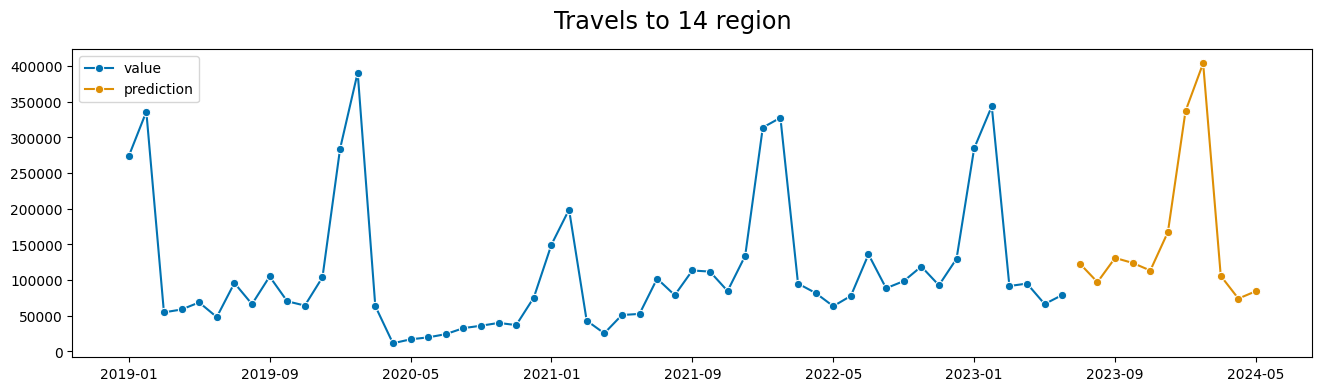

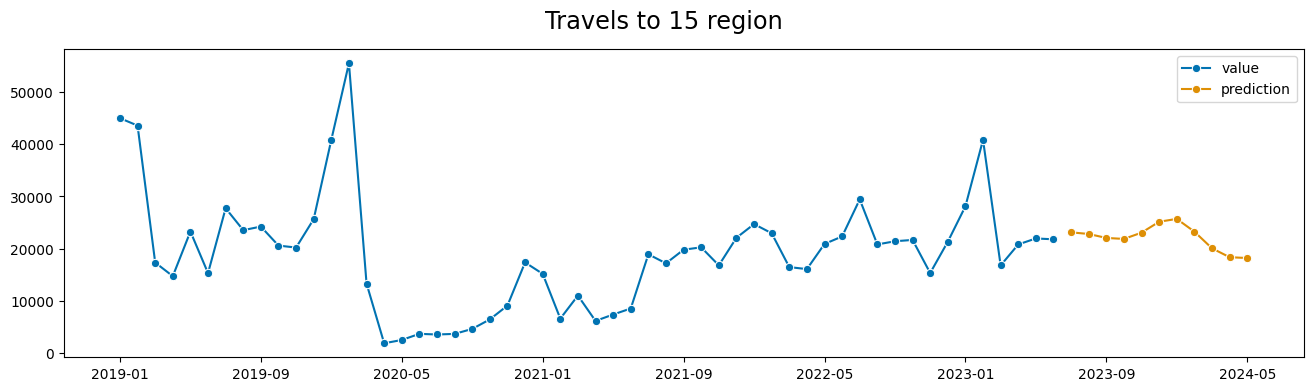

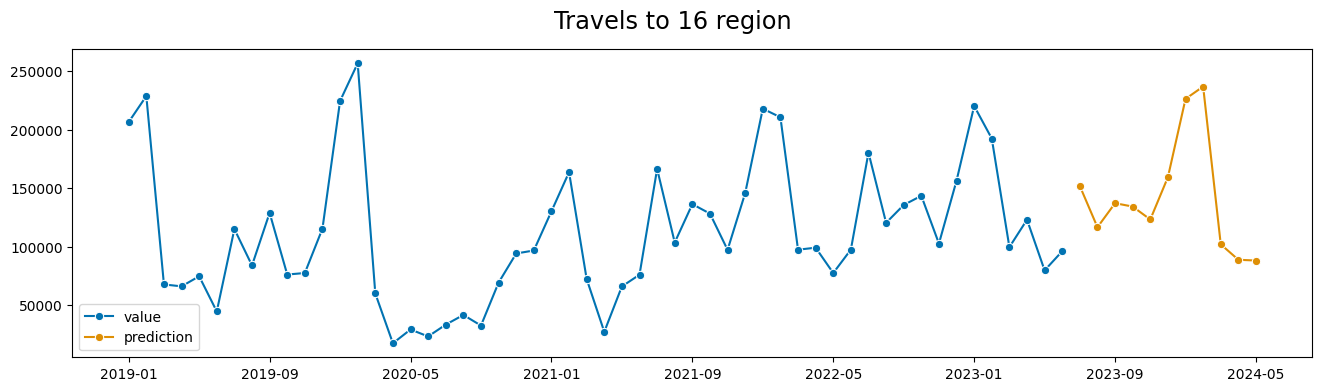

In [136]:
for rd in range(16):
    rd = rd + 1
    df_region = df_destiny_all[df_destiny_all.region_destiny == rd]
    df_y = df_region[pd.isna(df_region.prediction)]
    y = pd.Series(df_y.value.values, index= df_y.time_stamp.values)
    df_y_pred = df_region[pd.isna(df_region.value)]
    y_pred = pd.Series(df_y_pred.prediction.values, index= df_y_pred.time_stamp.values)
    plot_series(y, y_pred, labels=["value", "prediction"], title="Travels to {} region".format(rd))

